### Getting started - bring in TF and other dependencies for data loading
The data ingest is all from hangyao's github. I use it to get and shape the MNIST data for my test CNN in TF.

In [12]:
import tensorflow as tf
import numpy as np
import scipy as sp
from scipy import ndimage
import matplotlib.pyplot as plt
import os
import sys
import tarfile
from IPython.display import display, Image
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle

In [13]:
%matplotlib inline

In [14]:
url = 'http://commondatastorage.googleapis.com/books1000/'
last_percent_reported = None

def download_progress_hook(count, blockSize, totalSize):
  """A hook to report the progress of a download. This is mostly intended for users with
  slow internet connections. Reports every 1% change in download progress.
  """
  global last_percent_reported
  percent = int(count * blockSize * 100 / totalSize)

  if last_percent_reported != percent:
    if percent % 5 == 0:
      sys.stdout.write("%s%%" % percent)
      sys.stdout.flush()
    else:
      sys.stdout.write(".")
      sys.stdout.flush()
      
    last_percent_reported = percent
        
def maybe_download(filename, expected_bytes, force=False):
  """Download a file if not present, and make sure it's the right size."""
  if force or not os.path.exists(filename):
    print('Attempting to download:', filename) 
    filename, _ = urlretrieve(url + filename, filename, reporthook=download_progress_hook)
    print('\nDownload Complete!')
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified', filename)
  else:
    raise Exception(
      'Failed to verify ' + filename + '. Can you get to it with a browser?')
  return filename

train_filename = maybe_download('notMNIST_large.tar.gz', 247336696)
test_filename = maybe_download('notMNIST_small.tar.gz', 8458043)

('Found and verified', 'notMNIST_large.tar.gz')
('Found and verified', 'notMNIST_small.tar.gz')


In [15]:
num_classes = 10
np.random.seed(133)

def maybe_extract(filename, force=False):
  root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
  if os.path.isdir(root) and not force:
    # You may override by setting force=True.
    print('%s already present - Skipping extraction of %s.' % (root, filename))
  else:
    print('Extracting data for %s. This may take a while. Please wait.' % root)
    tar = tarfile.open(filename)
    sys.stdout.flush()
    tar.extractall()
    tar.close()
  data_folders = [
    os.path.join(root, d) for d in sorted(os.listdir(root))
    if os.path.isdir(os.path.join(root, d))]
  if len(data_folders) != num_classes:
    raise Exception(
      'Expected %d folders, one per class. Found %d instead.' % (
        num_classes, len(data_folders)))
  print(data_folders)
  return data_folders
  
train_folders = maybe_extract(train_filename)
test_folders = maybe_extract(test_filename)

notMNIST_large already present - Skipping extraction of notMNIST_large.tar.gz.
['notMNIST_large/A', 'notMNIST_large/B', 'notMNIST_large/C', 'notMNIST_large/D', 'notMNIST_large/E', 'notMNIST_large/F', 'notMNIST_large/G', 'notMNIST_large/H', 'notMNIST_large/I', 'notMNIST_large/J']
notMNIST_small already present - Skipping extraction of notMNIST_small.tar.gz.
['notMNIST_small/A', 'notMNIST_small/B', 'notMNIST_small/C', 'notMNIST_small/D', 'notMNIST_small/E', 'notMNIST_small/F', 'notMNIST_small/G', 'notMNIST_small/H', 'notMNIST_small/I', 'notMNIST_small/J']


In [21]:
image_size = 28  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.

def load_letter(folder, min_num_images):
  """Load the data for a single letter label."""
  image_files = os.listdir(folder)
  dataset = np.ndarray(shape=(len(image_files), image_size, image_size),
                         dtype=np.float32)
  print(folder)
  num_images = 0
  for image in image_files:
    image_file = os.path.join(folder, image)
    try:
        # took out normalization
      image_data = ndimage.imread(image_file).astype(float)
      if image_data.shape != (image_size, image_size):
        raise Exception('Unexpected image shape: %s' % str(image_data.shape))
      dataset[num_images, :, :] = image_data
      num_images = num_images + 1
    except IOError as e:
      print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
    
  dataset = dataset[0:num_images, :, :]
  if num_images < min_num_images:
    raise Exception('Many fewer images than expected: %d < %d' %
                    (num_images, min_num_images))
    
#   print('Full dataset tensor:', dataset.shape)
#   print('Mean:', np.mean(dataset))
#   print('Standard deviation:', np.std(dataset))
  return dataset
        
def maybe_pickle(data_folders, min_num_images_per_class, force=False):
  dataset_names = []
  for folder in data_folders:
    set_filename = folder + '.pickle'
    dataset_names.append(set_filename)
    if os.path.exists(set_filename) and not force:
      # You may override by setting force=True.
      print('%s already present - Skipping pickling.' % set_filename)
    else:
      print('Pickling %s.' % set_filename)
      dataset = load_letter(folder, min_num_images_per_class)
      try:
        with open(set_filename, 'wb') as f:
          pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
      except Exception as e:
        print('Unable to save data to', set_filename, ':', e)
  
  return dataset_names

train_datasets = maybe_pickle(train_folders, 40000)
# test_datasets = maybe_pickle(test_folders, 1800)

Pickling notMNIST_large/A.pickle.
notMNIST_large/A
('Could not read:', 'notMNIST_large/A/RnJlaWdodERpc3BCb29rSXRhbGljLnR0Zg==.png', ':', IOError("cannot identify image file 'notMNIST_large/A/RnJlaWdodERpc3BCb29rSXRhbGljLnR0Zg==.png'",), "- it's ok, skipping.")

ERROR:PIL.ImageFile:%s
Traceback (most recent call last):
  File "/usr/local/lib/python2.7/site-packages/PIL/ImageFile.py", line 100, in __init__
    self._open()
  File "/usr/local/lib/python2.7/site-packages/PIL/IptcImagePlugin.py", line 113, in _open
    layers = i8(self.info[(3, 60)][0])
KeyError: (3, 60)
ERROR:PIL.ImageFile:%s
Traceback (most recent call last):
  File "/usr/local/lib/python2.7/site-packages/PIL/ImageFile.py", line 100, in __init__
    self._open()
  File "/usr/local/lib/python2.7/site-packages/PIL/MpegImagePlugin.py", line 71, in _open
    if s.read(32) != 0x1B3:
  File "/usr/local/lib/python2.7/site-packages/PIL/MpegImagePlugin.py", line 53, in read
    v = self.peek(bits)
  File "/usr/local/lib/python2.7/site-packages/PIL/MpegImagePlugin.py", line 38, in peek
    c = self.next()
  File "/usr/local/lib/python2.7/site-packages/PIL/MpegImagePlugin.py", line 34, in next
    return i8(self.fp.read(1))
  File "/usr/local/lib/python2.7/site-packages/PIL/_binary.py", li


('Could not read:', 'notMNIST_large/A/SG90IE11c3RhcmQgQlROIFBvc3Rlci50dGY=.png', ':', IOError("cannot identify image file 'notMNIST_large/A/SG90IE11c3RhcmQgQlROIFBvc3Rlci50dGY=.png'",), "- it's ok, skipping.")

ERROR:PIL.ImageFile:%s
Traceback (most recent call last):
  File "/usr/local/lib/python2.7/site-packages/PIL/ImageFile.py", line 100, in __init__
    self._open()
  File "/usr/local/lib/python2.7/site-packages/PIL/IptcImagePlugin.py", line 113, in _open
    layers = i8(self.info[(3, 60)][0])
KeyError: (3, 60)
ERROR:PIL.ImageFile:%s
Traceback (most recent call last):
  File "/usr/local/lib/python2.7/site-packages/PIL/ImageFile.py", line 100, in __init__
    self._open()
  File "/usr/local/lib/python2.7/site-packages/PIL/MpegImagePlugin.py", line 71, in _open
    if s.read(32) != 0x1B3:
  File "/usr/local/lib/python2.7/site-packages/PIL/MpegImagePlugin.py", line 53, in read
    v = self.peek(bits)
  File "/usr/local/lib/python2.7/site-packages/PIL/MpegImagePlugin.py", line 38, in peek
    c = self.next()
  File "/usr/local/lib/python2.7/site-packages/PIL/MpegImagePlugin.py", line 34, in next
    return i8(self.fp.read(1))
  File "/usr/local/lib/python2.7/site-packages/PIL/_binary.py", li


('Could not read:', 'notMNIST_large/A/Um9tYW5hIEJvbGQucGZi.png', ':', IOError("cannot identify image file 'notMNIST_large/A/Um9tYW5hIEJvbGQucGZi.png'",), "- it's ok, skipping.")
Pickling notMNIST_large/B.pickle.
notMNIST_large/B

ERROR:PIL.ImageFile:%s
Traceback (most recent call last):
  File "/usr/local/lib/python2.7/site-packages/PIL/ImageFile.py", line 100, in __init__
    self._open()
  File "/usr/local/lib/python2.7/site-packages/PIL/IptcImagePlugin.py", line 113, in _open
    layers = i8(self.info[(3, 60)][0])
KeyError: (3, 60)
ERROR:PIL.ImageFile:%s
Traceback (most recent call last):
  File "/usr/local/lib/python2.7/site-packages/PIL/ImageFile.py", line 100, in __init__
    self._open()
  File "/usr/local/lib/python2.7/site-packages/PIL/MpegImagePlugin.py", line 71, in _open
    if s.read(32) != 0x1B3:
  File "/usr/local/lib/python2.7/site-packages/PIL/MpegImagePlugin.py", line 53, in read
    v = self.peek(bits)
  File "/usr/local/lib/python2.7/site-packages/PIL/MpegImagePlugin.py", line 38, in peek
    c = self.next()
  File "/usr/local/lib/python2.7/site-packages/PIL/MpegImagePlugin.py", line 34, in next
    return i8(self.fp.read(1))
  File "/usr/local/lib/python2.7/site-packages/PIL/_binary.py", li


('Could not read:', 'notMNIST_large/B/TmlraXNFRi1TZW1pQm9sZEl0YWxpYy5vdGY=.png', ':', IOError("cannot identify image file 'notMNIST_large/B/TmlraXNFRi1TZW1pQm9sZEl0YWxpYy5vdGY=.png'",), "- it's ok, skipping.")
Pickling notMNIST_large/C.pickle.
notMNIST_large/C
Pickling notMNIST_large/D.pickle.
notMNIST_large/D

ERROR:PIL.ImageFile:%s
Traceback (most recent call last):
  File "/usr/local/lib/python2.7/site-packages/PIL/ImageFile.py", line 100, in __init__
    self._open()
  File "/usr/local/lib/python2.7/site-packages/PIL/IptcImagePlugin.py", line 113, in _open
    layers = i8(self.info[(3, 60)][0])
KeyError: (3, 60)
ERROR:PIL.ImageFile:%s
Traceback (most recent call last):
  File "/usr/local/lib/python2.7/site-packages/PIL/ImageFile.py", line 100, in __init__
    self._open()
  File "/usr/local/lib/python2.7/site-packages/PIL/MpegImagePlugin.py", line 71, in _open
    if s.read(32) != 0x1B3:
  File "/usr/local/lib/python2.7/site-packages/PIL/MpegImagePlugin.py", line 53, in read
    v = self.peek(bits)
  File "/usr/local/lib/python2.7/site-packages/PIL/MpegImagePlugin.py", line 38, in peek
    c = self.next()
  File "/usr/local/lib/python2.7/site-packages/PIL/MpegImagePlugin.py", line 34, in next
    return i8(self.fp.read(1))
  File "/usr/local/lib/python2.7/site-packages/PIL/_binary.py", li


('Could not read:', 'notMNIST_large/D/VHJhbnNpdCBCb2xkLnR0Zg==.png', ':', IOError("cannot identify image file 'notMNIST_large/D/VHJhbnNpdCBCb2xkLnR0Zg==.png'",), "- it's ok, skipping.")
Pickling notMNIST_large/E.pickle.
notMNIST_large/E
Pickling notMNIST_large/F.pickle.
notMNIST_large/F
Pickling notMNIST_large/G.pickle.
notMNIST_large/G
Pickling notMNIST_large/H.pickle.
notMNIST_large/H
Pickling notMNIST_large/I.pickle.
notMNIST_large/I
Pickling notMNIST_large/J.pickle.
notMNIST_large/J


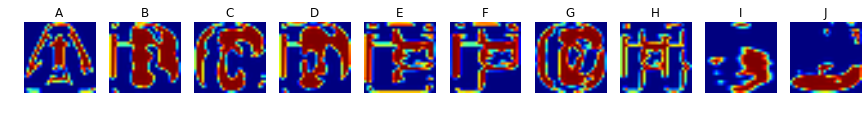

In [26]:
def read_from_pickle(filename):
    with open(filename, 'rb') as f:
          dataset = pickle.load(f)    
    return dataset

plt.rcParams['figure.figsize'] = (15.0, 15.0)
f, ax = plt.subplots(nrows=1, ncols=10)

img_num = np.random.randint(1,2000)

for i, filename in enumerate(train_datasets):
    image_slice = read_from_pickle(filename)[img_num, :, :]
    ax[i].axis('off')
    ax[i].set_title(filename[15], loc='center')
    ax[i].imshow(image_slice)
    
del image_slice

In [37]:
# Extracting a single letter A from the training set.
Aset_name = train_datasets[0]

In [38]:
Aset_test_img = read_from_pickle(Aset_name)[img_num, :, :]

In [39]:
Aset_test_img.shape

(28, 28)

In [41]:
def make_arrays(nb_rows, img_size):
    if nb_rows:
        dataset = np.ndarray((nb_rows, img_size, img_size), dtype=np.float32)
        labels = np.ndarray(nb_rows, dtype=np.int32)
    else:
        dataset, labels = None, None
    return dataset, labels

In [43]:
def merge_datasets(pickle_files, train_size, valid_size=0):
    num_classes = len(pickle_files)
    valid_dataset, valid_labels = make_arrays(valid_size, image_size)
    train_dataset, train_labels = make_arrays(train_size, image_size)
    vsize_per_class = valid_size // num_classes # floor division
    tsize_per_class = train_size // num_classes
    
    start_v, start_t = 0, 0
    end_v, end_t = vsize_per_class, tsize_per_class
    end_l = vsize_per_class+tsize_per_class
  
    for label, pickle_file in enumerate(pickle_files):       
        try:
            with open(pickle_file, 'rb') as f:
                letter_set = pickle.load(f)
                # let's shuffle the letters to have random validation and training set
                np.random.shuffle(letter_set)
                if valid_dataset is not None:
                    valid_letter = letter_set[:vsize_per_class, :, :]
                    valid_dataset[start_v:end_v, :, :] = valid_letter
                    valid_labels[start_v:end_v] = label
                    start_v += vsize_per_class
                    end_v += vsize_per_class
                    
                train_letter = letter_set[vsize_per_class:end_l, :, :]
                train_dataset[start_t:end_t, :, :] = train_letter
                train_labels[start_t:end_t] = label
                start_t += tsize_per_class
                end_t += tsize_per_class
        except Exception as e:
            print('Unable to process data from', pickle_file, ':', e)
            raise
    
    return valid_dataset, valid_labels, train_dataset, train_labels

In [44]:
train_size = 25000
valid_size = 20000
test_size = 5000
# Build train and validation sets.
valid_dataset, valid_labels, train_dataset, train_labels = merge_datasets(
  train_datasets, train_size, valid_size)

In [45]:
# Build test data set.
_, _, test_dataset, test_labels = merge_datasets(test_datasets, test_size)

In [46]:
valid_dataset.shape

(20000, 28, 28)

In [47]:
train_dataset.shape

(25000, 28, 28)

In [48]:
test_dataset.shape

(5000, 28, 28)

In [50]:
def randomize(dataset, labels):
    permutation = np.random.permutation(labels.shape[0])
    shuffled_dataset = dataset[permutation,:,:]
    shuffled_labels = labels[permutation]
    return shuffled_dataset, shuffled_labels
train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)
valid_dataset, valid_labels = randomize(valid_dataset, valid_labels)

In [51]:
# Put the data into a single pickle file.
pickle_file = 'notMNIST.pickle'

try:
    f = open(pickle_file, 'wb')
    save = {
        'train_dataset': train_dataset,
        'train_labels': train_labels,
        'valid_dataset': valid_dataset,
        'valid_labels': valid_labels,
        'test_dataset': test_dataset,
        'test_labels': test_labels,
    }
    pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
    f.close()
except Exception as e:
    print('Unable to save data to', pickle_file, ':', e)
    raise

In [52]:
train_r = train_dataset.reshape(train_dataset.shape[0],-1)
train_idx = np.lexsort(train_r.T)
train_dataset_sanitized = train_dataset[train_idx][np.append(True,(np.diff(train_r[train_idx],axis=0)!=0).any(1))]
train_labels_sanitized = train_labels[train_idx][np.append(True,(np.diff(train_r[train_idx],axis=0)!=0).any(1))]

valid_r = valid_dataset.reshape(valid_dataset.shape[0],-1)
valid_idx = np.lexsort(valid_r.T)
valid_dataset_sanitized = valid_dataset[valid_idx][np.append(True,(np.diff(valid_r[valid_idx],axis=0)!=0).any(1))]
valid_labels_sanitized = valid_labels[valid_idx][np.append(True,(np.diff(valid_r[valid_idx],axis=0)!=0).any(1))]

test_r = test_dataset.reshape(test_dataset.shape[0],-1)
test_idx = np.lexsort(test_r.T)
test_dataset_sanitized = test_dataset[test_idx][np.append(True,(np.diff(test_r[test_idx],axis=0)!=0).any(1))]
test_labels_sanitized = test_labels[test_idx][np.append(True,(np.diff(test_r[test_idx],axis=0)!=0).any(1))]

del train_r, valid_r, test_r

print('Training dataset has', train_dataset_sanitized.shape[0],'unique images.')
print('Sanitized training dataset has', train_dataset_sanitized.shape[0],'images.\n')
print('Validation dataset has', valid_dataset_sanitized.shape[0],'unique images.')
print('Test dataset has', test_dataset_sanitized.shape[0],'unique images.\n')

train_r = train_dataset_sanitized.reshape(train_dataset_sanitized.shape[0],-1)
valid_r = valid_dataset_sanitized.reshape(valid_dataset_sanitized.shape[0],-1)
test_r = test_dataset_sanitized.reshape(test_dataset_sanitized.shape[0],-1)

valid_dup = []
test_dup = []

train_r = {tuple(row):i for i,row in enumerate(train_r)}

for i,row in enumerate(valid_r):
    if tuple(row) in train_r:
        valid_dup.append(i)

for i,row in enumerate(test_r):
    if tuple(row) in train_r:
        test_dup.append(i)

print('Validation dataset has', len(valid_dup), 'duplicate images to training dataset.')
print('Test dataset has', len(test_dup), 'duplicate images to training dataset.\n')

valid_dataset_sanitized = np.delete(valid_dataset_sanitized, np.asarray(valid_dup), 0)
valid_labels_sanitized = np.delete(valid_labels_sanitized, np.asarray(valid_dup), 0)
test_dataset_sanitized = np.delete(test_dataset_sanitized, np.asarray(test_dup), 0)
test_labels_sanitized = np.delete(test_labels_sanitized, np.asarray(test_dup), 0)

print('Sanitized validation dataset has', valid_dataset_sanitized.shape[0],'images.')
print('Sanitized test dataset has', test_dataset_sanitized.shape[0],'images.')

('Training dataset has', 24546, 'unique images.')
('Sanitized training dataset has', 24546, 'images.\n')
('Validation dataset has', 19668, 'unique images.')
('Test dataset has', 4917, 'unique images.\n')
('Validation dataset has', 305, 'duplicate images to training dataset.')
('Test dataset has', 78, 'duplicate images to training dataset.\n')
('Sanitized validation dataset has', 19363, 'images.')
('Sanitized test dataset has', 4839, 'images.')


In [53]:
pickle_file = 'notMNIST_sanitized.pickle'

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset': train_dataset_sanitized,
    'train_labels': train_labels_sanitized,
    'valid_dataset': valid_dataset_sanitized,
    'valid_labels': valid_labels_sanitized,
    'test_dataset': test_dataset_sanitized,
    'test_labels': test_labels_sanitized,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise